In [37]:
# import packages
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from bt_classes import my_backtest
# orig_df = pd.read_csv('../res/test_data.csv',index_col=0,parse_dates=True)
# my_backtest(orig_df[:500])
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 20,10
# df = pd.read_csv('../res/input0130.csv')

orig_df = pd.read_csv('../xau_1d_20y.csv')
orig_df['datetime'] = pd.to_datetime(orig_df['date'])
orig_df = orig_df.set_index('datetime')

df = orig_df.copy()
df['log_r'] = np.log(df['close']) - np.log(df['open'])
df['label'] = np.sign(df['log_r'].shift(-1))
df['label'][df['label']==-1] = 0
df['label'].fillna(0,inplace=True)

In [45]:
# 失效的衡量：单点不算，而是去度量一个时间窗内的数据，比如说一个时间窗里的收益率、回撤、精确率准确率召回率、最大连续错误、交叉熵、
class test_indicator():
    def __init__(self, y_true, y_pred):
        assert len(y_pred) == len(y_true), f'Length of y is {len(y_pred)} while y_pred {len(y_true)}'
        self.y_pred = y_pred
        self.y_true = y_true
        self.suc_fail, fail_suc = np.array(self.successive_distribution())
        # 算这个比例是否要加权？
        self.successive_n_failure_rate = None
        self.period_entropy = None
        self.period_drawback = None
        self.volatility = None

    def successive_distribution(self):
        y_output = self.y_pred
        y = self.y_true
        continues_suc = 0
        continues_fail = 0
        result = []
        maxx = 0
        for i in range(0,len(y_output)):
            if y_output[i] == y[i]:
                continues_suc+=1
                if continues_fail!=0:
                    result.append(-continues_fail)
                    if continues_fail > maxx:
                        maxx = continues_fail
                    continues_fail = 0
            else:
                continues_fail+=1
                if continues_suc != 0:
                    result.append(continues_suc)
                    if continues_suc > maxx:
                        maxx = continues_suc
                    continues_suc = 0

        length = maxx+1
        suc_result = [[0] * length for i in range(length)]
        fail_result = [[0]*length for i in range(length)]

        for i in range(len(result)-1):
            if result[i]>0:
                suc_result[result[i]][-result[i+1]]+=1
            else:
                fail_result[-result[i]][result[i+1]]+=1
        return suc_result, fail_result

    def plot_suc_fail(self):
        plt.figure(figsize=(16,10))
        suc_result = pd.DataFrame(self.suc_fail).sort_index(ascending=False)
        sns.heatmap(suc_result.iloc[:-1,1:],cmap='Blues',annot=True, fmt='.0f')
        plt.yticks(rotation=0)
        ax = plt.gca()
        plt.xlabel('Successive Wrong',fontsize=16)
        plt.ylabel('Successive Correct',fontsize=16)
        plt.show()
        plt.close()

    def plot_fail_suc(self):
        plt.figure(figsize=(16,10))
        fail_result = pd.DataFrame(self.suc_fail).sort_index(ascending=False)
        sns.heatmap(fail_result.iloc[:-1,1:],cmap='Blues',annot=True, fmt='.0f')
        plt.yticks(rotation=0)
        ax = plt.gca()
        plt.xlabel('Successive Wrong',fontsize=16)
        plt.ylabel('Successive Correct',fontsize=16)
        plt.show()
        plt.close()

    def get_accuracy(self):
        return accuracy_score(self.y_true, self.y_pred)

    def get_precision(self):
        return precision_score(self.y_true, self.y_pred)

    def get_recall(self):
        return recall_score(self.y_true, self.y_pred)

    def get_successive_n_failure_rate(self,n=5):
        if n > len(self.suc_fail):
            return 0
        return self.suc_fail[:,n:].sum() / self.suc_fail.sum()

    def get_maximum_successive_failure(self):
        # TODO: calculate max failure number
        return 0

    def get_entropy(self):
        # TODO: calculate entropy
        return 0

    def get_drawback(self):
        # TODO: calculate maximum drawback of this phrase.
        return 0

    def get_volatility(self):
        # TODO
        return 0

In [ ]:
## 计算回撤、收益的模块可能要另外写，需要的输入跟上面的类有较大差别。可能需要整个价格的序列之类。这个再说吧

In [53]:
all_results = []
starter = range(2240,len(df)-250,250)
# all_results = []
for test_begin in starter:
    test_end = test_begin + 250
    this_test = pd.read_csv(f'{test_begin}_{test_end}_test.csv',index_col=0)
    ti = test_indicator(this_test['y_true'].values,this_test['y_pred'].values)
    this_result = [ti.get_accuracy(),ti.get_precision(),ti.get_recall(),ti.get_successive_n_failure_rate(3),ti.get_maximum_successive_failure(),ti.get_entropy()]
    all_results.append(this_result)

In [62]:
ars = pd.DataFrame(all_results,columns=['acc','pre','rec','suc_n_f','max_suc_f','ent'])
ars.sort_values('acc')

,acc,pre,rec,suc_n_f,max_suc_f,ent
6,0.480,0.480000,1.000000,0.185714,0,0
7,0.480,0.477178,0.966387,0.245902,0,0
0,0.484,0.484305,0.885246,0.222222,0,0
4,0.504,0.504000,1.000000,0.261538,0,0
5,0.504,0.504000,1.000000,0.181818,0,0
8,0.520,0.520492,0.976923,0.288136,0,0
10,0.524,0.524000,1.000000,0.138889,0,0
3,0.532,0.535270,0.962687,0.253968,0,0
1,0.540,0.557940,0.915493,0.246154,0,0
9,0.548,0.548000,1.000000,0.094595,0,0


In [58]:
from scipy.stats import pearsonr, spearmanr
pearsonr(ars['acc'],ars['suc_n_f']),spearmanr(ars['acc'],ars['suc_n_f'])

((-0.4589119174831324, 0.1556627663242073),
 SpearmanrResult(correlation=-0.3105055201845117, pvalue=0.35271482715942337))

In [61]:
pearsonr(ars['rec'],ars['suc_n_f']),spearmanr(ars['rec'],ars['suc_n_f'])

((-0.3794572822763239, 0.24973780428584974),
 SpearmanrResult(correlation=-0.42905816516051654, pvalue=0.18789757217207814))

In [8]:
y_true = np.random.randint(0,2,10000)
y_pred = np.random.randint(0,2,10000)

In [32]:
ti = test_indicator(y_true,y_pred)

In [38]:
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
# follow the literature
# we don't use min-max scaling here, use partial mean-std scaling instead
from sklearn.preprocessing import StandardScaler
from itertools import chain

# and we define our model here
def lstm_model(para_a=42, para_b=17):
    model = Sequential()
    model.add(LSTM(units=para_a, dropout=0.1, return_sequences=True, input_shape=(240,1),activation='tanh'))# (25,15)-57, (42,17)-58
    model.add(LSTM(units=para_b, dropout=0.08, activation='tanh'))
    # model.add(Dropout(0.08))# 加了之后同原先效果差不多，（应该一定程度上）可以防止过拟合
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.


## Method 1, train for only one time (many many days, maybe 2000?) and test several times(let's try 250 days per test). 

In [39]:
train_begin = 240
train_end = train_begin + 2000
scaler = StandardScaler()
train_set = df[['log_r','label']][train_begin-240:train_end].reset_index()
x_train, y_train = [], []
x_train_set = list(chain.from_iterable(scaler.fit_transform(train_set['log_r'].values.reshape(-1,1))))
for i in range(240,len(x_train_set)):
    x_train.append(x_train_set[i-240:i])
    y_train.append(train_set['label'][i])
x_train, y_train = np.array(x_train), np.array(y_train)
y_train = to_categorical(y_train,2)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 

model = lstm_model()
model.fit(x_train,y_train,epochs=30, batch_size=100, callbacks=[EarlyStopping(monitor='loss',patience=10)])


Epoch 1/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.6918 - accuracy: 0.5285
Epoch 2/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.6900 - accuracy: 0.5355
Epoch 3/30
2000/2000 [==============================] - 7s 4ms/step - loss: 0.6907 - accuracy: 0.5305
Epoch 4/30
2000/2000 [==============================] - 7s 4ms/step - loss: 0.6905 - accuracy: 0.5360
Epoch 5/30
2000/2000 [==============================] - 7s 4ms/step - loss: 0.6898 - accuracy: 0.5330
Epoch 6/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.6903 - accuracy: 0.5335
Epoch 7/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.6898 - accuracy: 0.5330
Epoch 8/30
2000/2000 [==============================] - 7s 4ms/step - loss: 0.6904 - accuracy: 0.5330
Epoch 9/30
2000/2000 [==============================] - 7s 4ms/step - loss: 0.6900 - accuracy: 0.5360
Epoch 10/30
2000/2000 [==============================] - 7s 4ms/step - loss: 0.6

In [40]:
model.save('d240-2240.h5')

In [50]:
starter = range(2240,len(df)-250,250)
# all_results = []
for test_begin in starter:
    test_end = test_begin + 250

    x_test, y_test = [], []
    test_set = df[['log_r','label']][test_begin-240:test_end].reset_index()
    y_true = df['label'][test_begin:test_end]
    display(y_true)
    x_test_set = list(chain.from_iterable(scaler.transform(test_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_test_set)):
        x_test.append(x_test_set[i-240:i])
        y_test.append(test_set['label'][i])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) 
    y_test = to_categorical(y_test,2)

    y_pred = model.predict_classes(x_test)

    to_save = pd.DataFrame()
    to_save['y_true'] = y_true
    to_save['y_pred'] = y_pred
    to_save.to_csv(f'{test_begin}_{test_end}_test.csv')
    # test_dsa = fetch_dsa(model, x_train, x_test, 'dsa from{}'.format(test_begin), layer_names, args)
    # dsa_cov = get_sc(np.amin(test_dsa), 5, 20, test_dsa)
    # test_lsa = fetch_lsa(model, x_train, x_test, 'lsa from{}'.format(test_begin), layer_names, args)
    # lsa_cov = get_sc(np.amin(test_lsa), 1500, 20, test_lsa)
    # eva = model.evaluate(x_test, y_test)
    # print('Loss: {:.2f}, Accuracy: {:.2f}'.format(eva[0], eva[1]))
    # print('Dsa Mean: {:.2f}, Var: {:.2f}, Max: {:.2f}, Min: {:.2f}'.format(np.mean(test_dsa),np.std(test_dsa),np.max(test_dsa),np.min(test_dsa)))
    # print('Lsa Mean: {:.2f}, Var: {:.2f}, Max: {:.2f}, Min: {:.2f}'.format(np.mean(test_lsa),np.std(test_lsa),np.max(test_lsa),np.min(test_lsa)))
    # test_df = orig_df[test_begin:test_end]
    # test_df['label'] = model.predict_classes(x_test)
    # sharpe,dd,ar = my_backtest(test_df)
    # this_result = [test_begin,eva[0], eva[1],dsa_cov,np.mean(test_dsa),np.std(test_dsa),np.max(test_dsa),np.min(test_dsa),lsa_cov,np.mean(test_lsa),np.std(test_lsa),np.max(test_lsa),np.min(test_lsa),sharpe,dd,ar]
    # all_results.append(this_result)

datetime
2008-08-04    0.0
2008-08-05    1.0
2008-08-06    0.0
2008-08-07    0.0
2008-08-08    0.0
             ... 
2009-07-13    1.0
2009-07-14    1.0
2009-07-15    0.0
2009-07-16    0.0
2009-07-17    1.0
Name: label, Length: 250, dtype: float64

datetime
2009-07-20    0.0
2009-07-21    1.0
2009-07-22    0.0
2009-07-23    1.0
2009-07-24    1.0
             ... 
2010-06-28    1.0
2010-06-29    1.0
2010-06-30    0.0
2010-07-01    1.0
2010-07-02    0.0
Name: label, Length: 250, dtype: float64

datetime
2010-07-05    0.0
2010-07-06    1.0
2010-07-07    0.0
2010-07-08    1.0
2010-07-09    0.0
             ... 
2011-06-13    1.0
2011-06-14    1.0
2011-06-15    0.0
2011-06-16    1.0
2011-06-17    1.0
Name: label, Length: 250, dtype: float64

datetime
2011-06-20    1.0
2011-06-21    1.0
2011-06-22    0.0
2011-06-23    0.0
2011-06-24    0.0
             ... 
2012-05-28    0.0
2012-05-29    1.0
2012-05-30    0.0
2012-05-31    1.0
2012-06-01    0.0
Name: label, Length: 250, dtype: float64

datetime
2012-06-04    0.0
2012-06-05    1.0
2012-06-06    0.0
2012-06-07    1.0
2012-06-08    1.0
             ... 
2013-05-13    0.0
2013-05-14    0.0
2013-05-15    0.0
2013-05-16    0.0
2013-05-17    1.0
Name: label, Length: 250, dtype: float64

datetime
2013-05-20    0.0
2013-05-21    0.0
2013-05-22    1.0
2013-05-23    0.0
2013-05-24    1.0
             ... 
2014-04-27    0.0
2014-04-28    0.0
2014-04-29    0.0
2014-04-30    0.0
2014-05-01    1.0
Name: label, Length: 250, dtype: float64

datetime
2014-05-02    1.0
2014-05-05    0.0
2014-05-06    0.0
2014-05-07    1.0
2014-05-08    1.0
             ... 
2015-04-10    0.0
2015-04-13    0.0
2015-04-14    1.0
2015-04-15    0.0
2015-04-16    1.0
Name: label, Length: 250, dtype: float64

datetime
2015-04-17    0.0
2015-04-20    1.0
2015-04-21    0.0
2015-04-22    1.0
2015-04-23    0.0
             ... 
2016-03-28    1.0
2016-03-29    0.0
2016-03-30    1.0
2016-03-31    0.0
2016-04-01    0.0
Name: label, Length: 250, dtype: float64

datetime
2016-04-04    1.0
2016-04-05    0.0
2016-04-06    1.0
2016-04-07    1.0
2016-04-08    1.0
             ... 
2017-03-16    1.0
2017-03-17    1.0
2017-03-20    1.0
2017-03-21    1.0
2017-03-22    0.0
Name: label, Length: 250, dtype: float64

datetime
2017-03-23    0.0
2017-03-24    1.0
2017-03-27    0.0
2017-03-28    1.0
2017-03-29    0.0
             ... 
2018-03-06    0.0
2018-03-07    0.0
2018-03-08    1.0
2018-03-09    0.0
2018-03-12    1.0
Name: label, Length: 250, dtype: float64

datetime
2018-03-13    0.0
2018-03-14    0.0
2018-03-15    0.0
2018-03-16    1.0
2018-03-19    0.0
             ... 
2019-02-20    0.0
2019-02-21    1.0
2019-02-22    0.0
2019-02-25    1.0
2019-02-26    0.0
Name: label, Length: 250, dtype: float64

In [2]:
from bt_classes import *
def my_backtest(mydata, log=False, drawpic=False, iplot=False):
    plt.rcParams['figure.figsize'] = 12,8
    cerebro = bt.Cerebro()
    data = MyPandasData(dataname=mydata)
    cerebro.adddata(data)
    if log:
        cerebro.addstrategy(GoldStrategy)
    else:
        cerebro.addstrategy(GoldStrategy_nolog)
    cerebro.addsizer(OptInvest)
    init_value= 100000.0
    cerebro.broker.setcash(init_value)
    cerebro.broker.setcommission(commission=0,automargin=0.01,mult=100)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe', timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade')
    cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='dd')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='ar')
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    thestrats = cerebro.run()
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % final_value)
    if drawpic:
        cerebro.plot(iplot=iplot,volume=False)
    sharpe = thestrats[0].analyzers.sharpe.get_analysis()['sharperatio']
    dd = thestrats[0].analyzers.dd.get_analysis()['max']['drawdown']
    ar = thestrats[0].analyzers.returns.get_analysis()['rnorm100']
    rt = thestrats[0].analyzers.returns.get_analysis()['ravg']
    sqn = thestrats[0].analyzers.sqn.get_analysis()
    # print(thestrats[0].analyzers.sharpe.get_analysis())
    print('Sharpe: {:.2f}'.format(sharpe))
    print('Max drawdown: {:.2f}%'.format(dd))
    print('Annual rate: {:.2f}%'.format(ar))
    print('Num of trades: {}'.format(sqn['trades']))
    print(rt)
    print('Average return per trade: {:.2f}%'.format(rt*100/sqn['trades']))
    # print(thestrats[0].analyzers.sqn.get_analysis())
    return sharpe,dd,ar

In [8]:
from keras.models import load_model
model = load_model('more_lstm.h5')
train_begin = 240
train_end = train_begin + 10000
train_df = orig_df[train_begin:train_end]
train_df['label'] = model.predict_classes(x_train)
my_backtest(train_df,drawpic=True,iplot=False,log=False)

Starting Portfolio Value: 100000.00
Final Portfolio Value: 52885.16


<IPython.core.display.Javascript object>

Sharpe: 0.03
Max drawdown: 84.01%
Annual rate: -3.18%
Num of trades: 539
-0.00012817855448292087
Average return per trade: -0.00%


(0.02833997444973924, 84.01448694329665, -3.178489039800472)

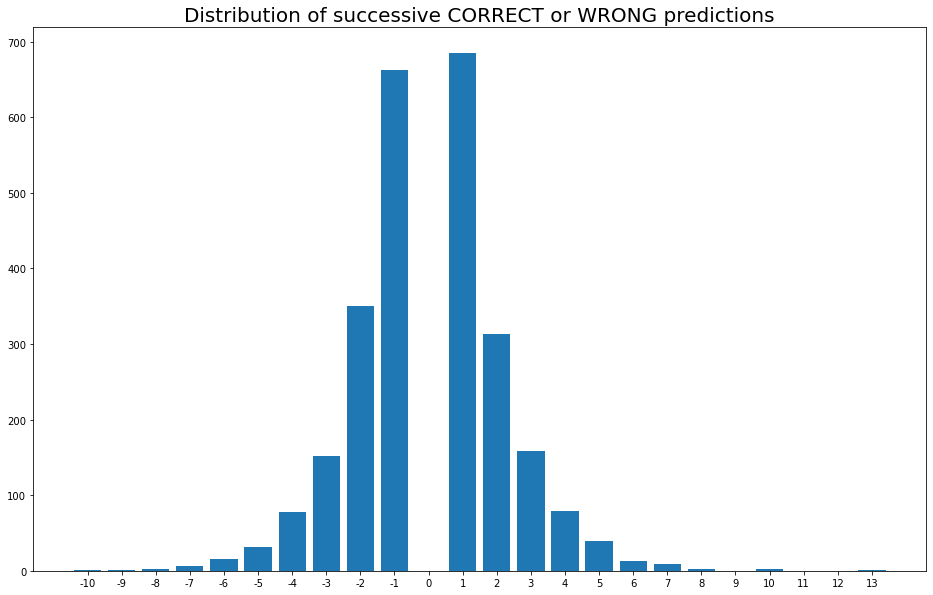

In [122]:
res = pd.DataFrame(result,columns=['successive']).reset_index().groupby('successive').count().reset_index()
plt.figure(figsize=(16,10))
plt.bar(res['successive'],res['index'],)
plt.xticks([x for x in range(np.min(result),np.max(result)+1)],list(range(np.min(result),np.max(result)+1)))
plt.title('Distribution of successive CORRECT or WRONG predictions',fontsize=20)
plt.show()

In [124]:
res['successive'].skew(),res['successive'].kurt()

(0.18400975803441041, -0.9946088335738192)

In [ ]:
from tqdm import tqdm
from sa import *
from utils import *

# Please select the last activation layer.
layer_names = ['lstm_6']

default_upper_bound = 2000
default_n_bucket = 1000
default_n_classes = 2
class Args(): #创建一个类
    def __init__(self): #定义初始化信息。
        self.is_classification = True
        self.save_path = './tmp/'
        self.d = 'lstm_r'
        self.num_classes = 2
        self.lsa = True
        self.dsa = True
        self.target = 'none'
        self.batch_size = 128
        self.var_threshold = 1e-5
        self.upper_bound = 2000
        self.n_bucket = 1000
        self.is_classification = True
args = Args()

In [ ]:
starter = range(10240,len(df)-250,250)
all_results = []

for test_begin in starter:
    test_end = test_begin + 250

    x_test, y_test = [], []
    test_set = df[['log_r','label']][test_begin-240:test_end].reset_index()
    x_test_set = list(chain.from_iterable(scaler.transform(test_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_test_set)):
        x_test.append(x_test_set[i-240:i])
        y_test.append(test_set['label'][i])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) 
    y_test = to_categorical(y_test,2)

    test_dsa = fetch_dsa(model, x_train, x_test, 'dsa from{}'.format(test_begin), layer_names, args)
    dsa_cov = get_sc(np.amin(test_dsa), 5, 20, test_dsa)
    test_lsa = fetch_lsa(model, x_train, x_test, 'lsa from{}'.format(test_begin), layer_names, args)
    lsa_cov = get_sc(np.amin(test_lsa), 1500, 20, test_lsa)
    eva = model.evaluate(x_test, y_test)
    print('Loss: {:.2f}, Accuracy: {:.2f}'.format(eva[0], eva[1]))
    print('Dsa Mean: {:.2f}, Var: {:.2f}, Max: {:.2f}, Min: {:.2f}'.format(np.mean(test_dsa),np.std(test_dsa),np.max(test_dsa),np.min(test_dsa)))
    print('Lsa Mean: {:.2f}, Var: {:.2f}, Max: {:.2f}, Min: {:.2f}'.format(np.mean(test_lsa),np.std(test_lsa),np.max(test_lsa),np.min(test_lsa)))
    test_df = orig_df[test_begin:test_end]
    test_df['label'] = model.predict_classes(x_test)
    sharpe,dd,ar = my_backtest(test_df)
    this_result = [test_begin,eva[0], eva[1],dsa_cov,np.mean(test_dsa),np.std(test_dsa),np.max(test_dsa),np.min(test_dsa),lsa_cov,np.mean(test_lsa),np.std(test_lsa),np.max(test_lsa),np.min(test_lsa),sharpe,dd,ar]
    all_results.append(this_result)

In [ ]:
cols = ['test_begin','loss', 'accu','dsa_cov','dsa_mean','dsa_std','dsa_max','dsa_min','lsa_cov','lsa_mean','lsa_std','lsa_max','lsa_min','sharpe','drawdown','annual_return']
result_df = pd.DataFrame(all_results,columns=cols)

In [ ]:
result_df.to_csv('rs.csv')